In [1]:
import keras
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'2.3.1'

Data preprocessing

In [406]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    labels = ["train_set", "val_set", "test_set"]
    for i,dataset in enumerate([train_set, val_set, test_set]):
        totalsize = sum([len(x)*34 for x in dataset[0]])
        non_zero_elements = sum([np.count_nonzero(x) for x in dataset[0]])
        zero_elements = totalsize-non_zero_elements
        print("{} shape: {}".format(labels[i], dataset[0].shape))
        print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
    return train_set, val_set, test_set

In [407]:
MODEL_NAME = "PoseNet-101"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 58106/13984574 (0.42%)
val_set shape: (1365,)
val_set zero elements: 15980/3509310 (0.46%)
test_set shape: (759,)
test_set zero elements: 9588/1973564 (0.49%)


In [400]:
len(train_set[0][0]),train_set[0][0][:]
# , train_set[0][0]

(53, [array([[ 326.86267113, 1009.42954219],
         [ 317.15314689, 1007.46991591],
         [ 313.94384354, 1000.33777971],
         [ 329.16923082, 1001.30003135],
         [ 317.83803499,  974.96060754],
         [ 374.50710521,  956.76926128],
         [ 380.41574228,  967.69711623],
         [ 463.23393613,  965.592876  ],
         [ 454.81399166,  972.57160947],
         [ 533.76179804, 1006.10547401],
         [ 534.82846049, 1010.21552623],
         [ 534.09603474,  961.36619627],
         [ 524.34286596,  958.27864179],
         [ 651.32237928,  962.71496417],
         [ 650.51933136,  974.52116728],
         [ 753.24499055,  955.07290063],
         [ 753.05911607,  956.64850675]]),
  array([[ 327.54946894, 1008.81090008],
         [ 317.65872596, 1006.88799354],
         [ 314.80650915, 1000.2105338 ],
         [ 329.19149369, 1000.39141931],
         [ 318.19496963,  973.90044689],
         [ 375.91498831,  955.36702749],
         [ 380.32955898,  965.75365661],
         [

In [ ]:
# it removes the zeros from the dataset features taking the previous non-zero value 
#(or the first non-zero value in case of the first frame)
def removeZerosFromFeatures(features):
    

In [380]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels
    
from sklearn.model_selection import StratifiedShuffleSplit
def balancedSplitting(features, labels, test_size = 0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_idx, test_idx in sss.split(features, labels):
        X_train = features[train_idx]
        y_train = labels[train_idx]
        X_test = features[test_idx]
        y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test
    
    
from keras.preprocessing.sequence import pad_sequences
# def padding(features, max):
#     maxLength = max([len(s) for s in  features])
#     newFeatures = pad_sequences(features, maxlen=None, dtype='float32', padding='post', truncating='post', value=0.0)
#     lenght = newFeatures.shape[0] * newFeatures.shape[1]*newFeatures.shape[2]*newFeatures.shape[3]
#     numberOfZeros = np.count_nonzero(newFeatures==0)
#     print("number of zeros(after padding): {} - {:.2f}%".format(numberOfZeros, numberOfZeros/(lenght)*100))
#     print("Dataset shape: ", newFeatures.shape)
#     return newFeatures

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
        maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    newXtrain = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXval = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXtest = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    
    ### stats ######################################
    labels = ["train set", "val set", "test set"]
    for i, dataset in enumerate([newXtrain, newXval, newXtest]):
        totalsize = dataset.shape[0] * dataset.shape[1]*dataset.shape[2]*dataset.shape[3]
        non_zero_elements = sum([np.count_nonzero(x) for x in dataset])
        zero_elements = totalsize-non_zero_elements
        print("{} shape: {}".format(labels[i], dataset.shape))
        print("{} zero elements (after padding): {} ({:.2f}%)".format(labels[i],zero_elements,zero_elements*100/totalsize))
    
    return newXtrain, newXval, newXtest

In [381]:
newXtrain, newXval, newXtest = paddingTrainValTest(train_set[0], val_set[0], test_set[0])

train set shape: (5460, 225, 17, 2)
train set zero elements (after padding): 27842532 (66.66%)
val set shape: (1365, 225, 17, 2)
val set zero elements (after padding): 6948920 (66.55%)
test set shape: (759, 225, 17, 2)
test set zero elements (after padding): 3842374 (66.18%)


In [374]:
sum([len(x)*34 for x in X_train]), X_train.shape[0] * X_train.shape[1]*X_train.shape[2]*X_train.shape[3]


array([list([array([[ 326.86267113, 1009.42954219],
       [ 317.15314689, 1007.46991591],
       [ 313.94384354, 1000.33777971],
       [ 329.16923082, 1001.30003135],
       [ 317.83803499,  974.96060754],
       [ 374.50710521,  956.76926128],
       [ 380.41574228,  967.69711623],
       [ 463.23393613,  965.592876  ],
       [ 454.81399166,  972.57160947],
       [ 533.76179804, 1006.10547401],
       [ 534.82846049, 1010.21552623],
       [ 534.09603474,  961.36619627],
       [ 524.34286596,  958.27864179],
       [ 651.32237928,  962.71496417],
       [ 650.51933136,  974.52116728],
       [ 753.24499055,  955.07290063],
       [ 753.05911607,  956.64850675]]), array([[ 327.54946894, 1008.81090008],
       [ 317.65872596, 1006.88799354],
       [ 314.80650915, 1000.2105338 ],
       [ 329.19149369, 1000.39141931],
       [ 318.19496963,  973.90044689],
       [ 375.91498831,  955.36702749],
       [ 380.32955898,  965.75365661],
       [ 462.82609173,  963.79877649],
       [ 4

In [4]:
import matplotlib.pyplot as plt 
def plotLabels(y_train,y_test):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot("211")
    ax.set_title("Train", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8) 

    ax = plt.subplot("212")
    ax.set_title("Test", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8)

    plt.show()

In [5]:
def normaliseBeforePadding(X_train, X_val, X_test):
    trainAndVal = np.concatenate((X_train, X_val), axis=0)
    print("normalising train, val and test values BEFORE padding")
    trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
    trainStd = np.vstack(trainAndVal).std()
    normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
    normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
    normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])
    
    return normalized_X_train, normalized_X_val, normalized_X_test
    
    

In [6]:
def relativeToVideoCenter(X):
    print("Adapting the data to the center of each video")
    newX = X.copy()
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        newX[i] = [frame-videoMean for frame in frames]

    return newX

# Posenet predicts:
# 1 - nose 
# 2 - leftEye 
# 3 - rightEye 
# 4 - leftEar 
# 5 - rightEar

# 6 - leftShoulder 
# 7 - rightShoulder
# 8 - leftElbow 
# 9 - rightElbow 
# 10 - leftWrist
# 11 - rightWrist 

# 12 - leftHip 
# 13 - rightHip 
# 14 - leftKnee 
# 15 - rightKnee 
# 16 - leftAnkle
# 17 - rightAnkle

def relativeToUpperMiddleBottomCentersOfFrame(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            newX[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
            newX[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
            newX[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
    return newX

def relativeToUpperMiddleBottomCentersOfVideo(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each video")
    newX = X.copy()
    
    for i_video,frames in enumerate(X):        
        videoUpperMean = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMean = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMean = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        for i_frame, frame in enumerate(frames):
            newX[i_video][i_frame][:5] = frame[:5] - videoUpperMean
            newX[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMean
            newX[i_video][i_frame][11:17] = frame[11:17] - videoBottomMean
    return newX

def relativeToFrameCenter(X):
    print("Adapting the data to the center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            newX[i_video][i_frame] = frame - frame_mean

    return newX

In [7]:
def relativeToNextFrame(X):
    print("Adapting the data to the next frame")
    newX = []
    for frames in X:
        motions = []
        for i in range(len(frames)-1):
            motions.append(np.array(frames[i+1])-np.array(frames[i]))
        newX.append(motions)
    return np.array(newX)
  

In [8]:
def preprocessData(train_set, val_set, test_set, normalize: bool, preprocess_functions = None):
    X_train, X_val, X_test = train_set[0].copy(), val_set[0].copy(), test_set[0].copy()
    # one hot encoding
    y_train = one_hot_encoding(train_set[1].copy())
    y_val = one_hot_encoding(val_set[1].copy())
    y_test = one_hot_encoding(test_set[1].copy())

    # preprocess
    if preprocess_functions is not None:
        for preprocess_function in preprocess_functions:
            X_train = preprocess_function(X_train)
            X_val = preprocess_function(X_val)
            X_test = preprocess_function(X_test)
    
    # normalize
    if normalize:
        X_train, X_val, X_test = normaliseBeforePadding(X_train, X_val, X_test)
    
    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)
    
    ## reshaping ###
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, X_val, X_test = train_set[0].copy(), val_set[0].copy(), test_set[0].copy()
# one hot encoding
y_train = one_hot_encoding(train_set[1].copy())
y_val = one_hot_encoding(val_set[1].copy())
y_test = one_hot_encoding(test_set[1].copy())

# preprocess
if preprocess_functions is not None:
    for preprocess_function in preprocess_functions:
        X_train = preprocess_function(X_train)
        X_val = preprocess_function(X_val)
        X_test = preprocess_function(X_test)

# normalize
if normalize:
    X_train, X_val, X_test = normaliseBeforePadding(X_train, X_val, X_test)

#padding
X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)

## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

X_train, y_train, X_val, y_val, X_test, y_test

In [338]:
min([len(x) for x in X_train]),np.argmin([len(x) for x in X_train])

(29, 221)

In [373]:
# import tensorflow as tf
# randomVideo = X_train[221]
# len(randomVideo), randomVideo[0], type(randomVideo[0])
# np.count_nonzero(randomVideo[-6]==0)
# np.count_nonzero(X_train[221][-6]==0),np.count_nonzero(X_train[221]), len(X_train[221]*34)
totalsize = sum([len(x)*34 for x in X_train])
non_zero_elements = sum([np.count_nonzero(x) for x in X_train])
zero_elements = totalsize-non_zero_elements
print("zero elements: {} ({}%)".format(zero_elements,zero_elements*100/totalsize))
# tf.math.count_nonzero(X_train[221]==0)

zero elements: 58106 (0.4155006795344642%)


In [350]:
randomVideo[-6]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [333]:
type(X_train[0]),len(X_train[0])

(list, 53)

In [203]:
x,y = zip(*[(f[0][0], f[0][1]) for f in randomVideo])

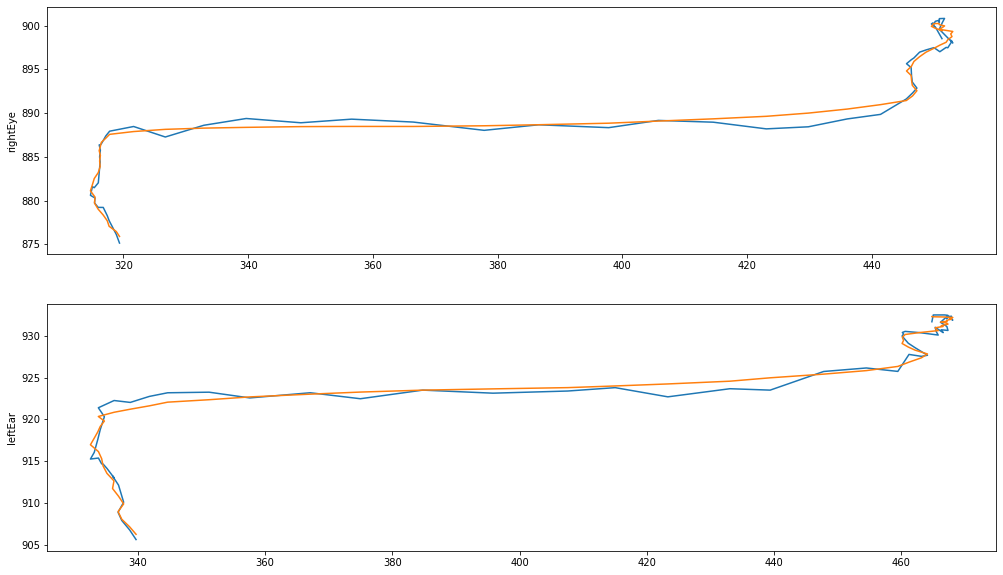

In [302]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
listOfPoints = [2,3]
fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)
fig.set_size_inches((17,len(listOfPoints)*5))
for i, p in enumerate(listOfPoints):
    axes[i].set_ylabel(legend[p])
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    ts = Series(y, index=x)
    # ts = ts.cumsum()
    ts.plot(ax=axes[i])
    
    smooth_y=signal.savgol_filter(ts.get_values(),
                           29, # window size used for filtering
                           3), # order of fitted polynomial

    ts2 = Series(smooth_y[0], index=x)

    ts2.plot(ax=axes[i])

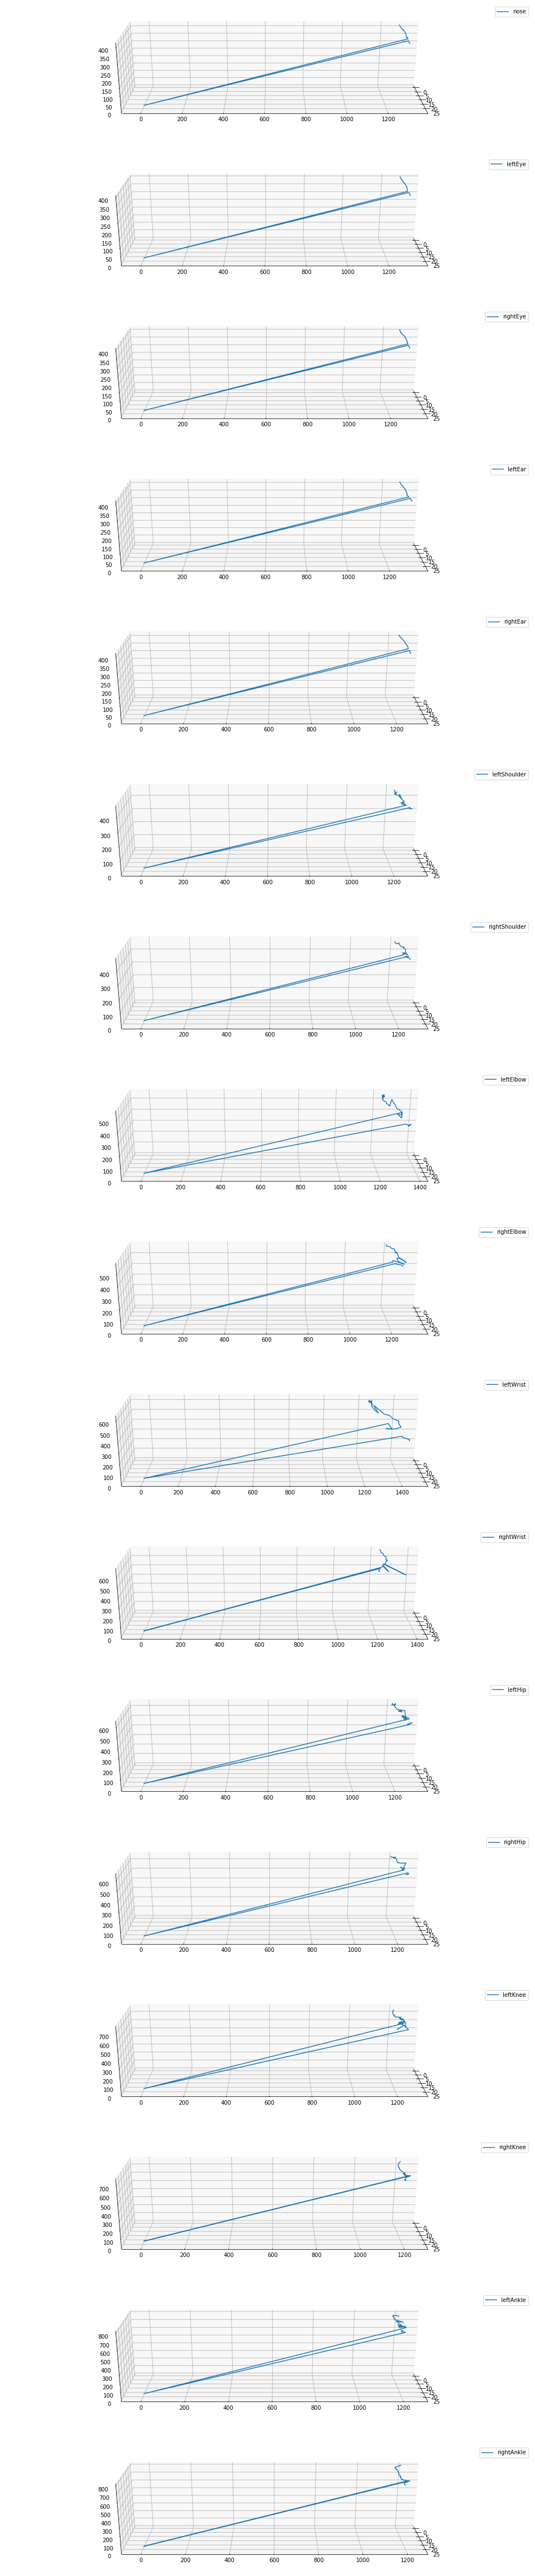

In [341]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
listOfPoints = list(range(17))
# listOfPoints = [5,7,9]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(20, 0)
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p])
#     smooth_y=signal.savgol_filter(y, window, order) 
#     smooth_x=signal.savgol_filter(x, window, order)
#     ax.plot(z,smooth_y,smooth_x,label="smoothed {} {}".format(window,order))
    
#     smooth_y=signal.savgol_filter(y, 19, 5) 
#     smooth_x=signal.savgol_filter(x, 19, 5)
#     ax.plot(z,smooth_y,smooth_x,label="smoothed 19 5")
    
#     smooth_y=signal.savgol_filter(y, 9, 5) 
#     smooth_x=signal.savgol_filter(x, 9, 5)
#     ax.plot(z,smooth_y,smooth_x,label="smoothed 9 5")
    
    
    ax.legend()

plt.show()
  

In [117]:
import scipy
from scipy import signal

def smoothingPoints(window, order):
    movingWindow = window
    polynomialOrder = order
    
    def smooth(X):
        def getHyperParameter():
            return movingWindow,polynomialOrder
        
        return 3
#     Savitzky-Golay
#         y=signal.savgol_filter(y,
#                                53, # window size used for filtering
#                                3), # order of fitted polynomial
        
    
    return smooth, window, order

In [118]:
import gc
function= smoothingPoints(53,3)
# function.getHyperParameter()
# function.getHyperParameter()
# gc.get_referents(function)
function

(<function __main__.smoothingPoints.<locals>.smooth>, 53, 3)

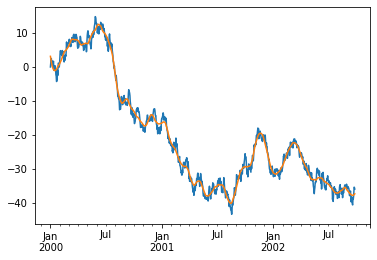

In [116]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal


# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(1000), index=date_range('1/1/2000', periods=1000))
ts = ts.cumsum()
ts.plot()

y=signal.savgol_filter(ts.get_values(),
                       53, # window size used for filtering
                       3), # order of fitted polynomial
    
ts2 = Series(y[0], index=date_range('1/1/2000', periods=1000))

ts2.plot()

# Loading data

In [187]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
SAVED_MODEL_FOLDER += "1-layer-relativeToNextFrameTests/"
MODEL_NAME = "PoseNet-101"
# MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
PREPROCESS_FUNCTION_TO_TEST = [
    ([smoothingPoints(29,3), relativeToNextFrame], True)
#     ,([smoothingPoints(29,5), relativeToNextFrame], True)
#     ,([smoothingPoints(29,7), relativeToNextFrame], True)
#     ,([smoothingPoints(29,9), relativeToNextFrame], True)
]
# NORMALIZE = False
SAVED_MODEL_FOLDER 

'/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/1-layer-relativeToNextFrameTests/'

In [128]:
# PREPROCESS_FUNCTION_TO_TEST[0][0][0].__movingWindow
for i, (((preprocess_function1, par1,par2), preprocess_function2 ), normalise) in enumerate(PREPROCESS_FUNCTION_TO_TEST):
    print( i, preprocess_function1, par1,par2, preprocess_function2 , normalise )
    

0 <function smoothingPoints.<locals>.smooth at 0x7f85695dd488> 53 3 <function relativeToNextFrame at 0x7f857051a6a8> True


## sequential trainings

In [151]:
def getSaveFileName(modelName,preprocess_functions,normalize):
    saveFileName = modelName
    if preprocess_functions is not None:
        for function in preprocess_functions:
            if callable(function):
                saveFileName += "-{}".format(function.__name__) 
            else:
                for component in function:
                    if callable(component):
                        saveFileName += "-{}".format(component.__name__) # in case it's a function
                    else: 
                        saveFileName += "-{}".format(component) # in case it's a parameter value
                    print(saveFileName)
                
    if normalize:
        saveFileName += "-norm"
    
    return saveFileName

In [188]:
import dill
from keras import models,layers
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

BATCH_SIZE = 32
EPOCHS = 1 #the earlystop will stop the training
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=100, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)
callbacks_list = [earlyStop]

for i, (preprocess_functions, normalize) in enumerate(PREPROCESS_FUNCTION_TO_TEST[:1]):
    ### Determining save file name ###
    saveFileName = getSaveFileName(MODEL_NAME,preprocess_functions,normalize)
        
    print("######## {}/{} - {} ########".format(i+1, len(PREPROCESS_FUNCTION_TO_TEST), saveFileName))
    print("## To be saved in [...]{} ###".format(SAVED_MODEL_FOLDER[54:]))
    
    ### Loading dataset ###
#     datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
#     print("#### Loading dataset: ", datasetName)
#     train_set, val_set, test_set = getData(datasetName)
    
#     ### Preprocess ###
#     X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, 
#                                                                     val_set, 
#                                                                     test_set, 
#                                                                     normalize, 
#                                                                     preprocess_functions)
    
#     ### Defining model ###
#     length_in_frames = X_train.shape[1]
    
#     model = models.Sequential()
#     model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2))
#     model.add(layers.Dense(8, activation='softmax'))

#     model.compile(optimizer='rmsprop',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     ## Fit ###    
#     history = model.fit(X_train, y_train,
#                         epochs=EPOCHS,
#                         batch_size=BATCH_SIZE,
#                         callbacks=callbacks_list,
#                         validation_data=(X_val, y_val)
#                        )

#     ### save model
#     model.save(SAVED_MODEL_FOLDER+saveFileName+".h5")
    
#     ### save history and preprocess functions
#     prep_functions = [one_hot_encoding, 
#                       normaliseBeforePadding, 
#                       paddingTrainValTest, 
#                       preprocessData] + preprocess_functions
#     with open(SAVED_MODEL_FOLDER+saveFileName+".pickle","wb") as handle:
#         pickle.dump({"history":history, "prep_fun_DILL":[dill.dumps(x) for x in prep_functions]}, handle) 
#         print("## Saved in {} ###\n\n".format(SAVED_MODEL_FOLDER+saveFileName+".pickle"))
print("DONE!")

PoseNet-101-smooth
PoseNet-101-smooth-29
PoseNet-101-smooth-29-3
######## 1/1 - PoseNet-101-smooth-29-3-relativeToNextFrame-norm ########
## To be saved in [...]/savedModels/1-layer-relativeToNextFrameTests/ ###
DONE!


In [150]:
getSaveFileName(MODEL_NAME,preprocess_functions,normalize)

PoseNet-101-smooth
PoseNet-101-smooth-53
PoseNet-101-smooth-53-3


In [14]:
for i, (specific_function, normalize) in enumerate(COMBINATIONS_TO_TEST):
    print(i,specific_function,normalize)

0 <function relativeToNextFrame at 0x7fab0effd7b8> True
1 <function relativeToUpperMiddleBottomCentersOfVideo at 0x7fab0effdea0> True
2 <function relativeToVideoCenter at 0x7fab0fd56e18> True


## load values

In [ ]:
import dill
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences

MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)


with open('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/PoseNet-101-relativeToNextFrame.pickle',"rb") as handle:
    res = pickle.load(handle)
    
loaded_functions = [dill.loads(x) for x in res["prep_fun_DILL"]]

one_hot_encoding = loaded_functions[0]
normaliseBeforePadding = loaded_functions[1]
paddingTrainValTest = loaded_functions[2]
preprocessData = loaded_functions[3]
relativeToNextFrame = loaded_functions[4]

## old method

In [ ]:
## Determining save file name
saveFileName = MODEL_NAME
for fun in PREPROCESS_FUNCTIONS:
    saveFileName += "-{}".format(fun.__name__)

if NORMALIZE:
    saveFileName += "-norm"

saveFileName +=".h5"
saveFileName

In [9]:
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)

number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)


## Preprocessing

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, NORMALIZE, PREPROCESS_FUNCTIONS)

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
number of zeros train (after padding):		27798672 - 66.55%
number of zeros validation (after padding):	6951708 - 66.57%
number of zeros test (after padding):		3883446 - 66.88%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)


In [ ]:
## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

# Defining model

In [13]:
from keras import models,layers
from keras.layers import LSTM
BATCH_SIZE = 32
length_in_frames = X_train.shape[1]
model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', input_shape=(BATCH_SIZE, length_in_frames, 17 * 2)))
model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

EPOCHS = 3000 #the earlystop will stop the training
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
#                     validation_split=0.2
                    validation_data=(X_val, y_val)
                   )

model.save(SAVED_MODEL_FOLDER+saveFileName)


Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0805 - accuracy: 0.1183 - val_loss: 2.0788 - val_accuracy: 0.1275
Epoch 2/3000
5460/5460 [==============================] - 22s 4ms/step - loss: 2.0799 - accuracy: 0.1227 - val_loss: 2.0786 - val_accuracy: 0.1275
Epoch 3/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0799 - accuracy: 0.1238 - val_loss: 2.0769 - val_accuracy: 0.1289
Epoch 4/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.9958 - accuracy: 0.1764 - val_loss: 1.8582 - val_accuracy: 0.2198
Epoch 5/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8107 - accuracy: 0.2269 - val_loss: 1.7355 - val_accuracy: 0.2454
Epoch 6/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.6389 - accuracy: 0.2936 - val_loss: 1.6151 - val_accuracy: 0.2828
Epoch 7/3000
5460/5460 [==============================] - 19s 4ms/ste

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
max(acc),max(val_acc),min(loss),min(val_loss)

In [ ]:
np.argmax(val_acc)

## Display results

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
# ACTION_LABEL_SET = 
    # A001  - A002 - A023          - A031               -  A049     - A007  - A008     - A009         
    # drink - eat -  hand waving   - point to something - use a fan - throw - sit down - standing up
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc
        
def plotValTestResult(model, x_val, y_val, x_test, y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    print("Val acc:",val_acc)
    print("Test acc:",test_acc)
    conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
    conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
    plotConfusionMatrixes(conf_mat_val,conf_mat_test)
    return val_acc, test_acc

import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = ["drink", "eat", "hand wave", "point-to", "fan", "throw", "sit-down", "stand-up"]):
    plt.figure(figsize = (15,7))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(1, 2, 2)
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()
    

## display model results

In [14]:
functionMap = {
    "relativeToFrameCenter": relativeToFrameCenter,
    "relativeToNextFrame": relativeToNextFrame,
    "relativeToVideoCenter": relativeToVideoCenter,
    "relativeToUpperMiddleBottomCentersOfFrame": relativeToUpperMiddleBottomCentersOfFrame,
    "relativeToUpperMiddleBottomCentersOfVideo": relativeToUpperMiddleBottomCentersOfVideo}
def fromFileNameToParameters(fileName):
    parsedName = fileName.name[:-3].split("-")
    
    normalise = False
    if parsedName[-1]=="norm":
        normalise = True
        parsedName = parsedName[:-1]
        
    modelName = parsedName[0]
    parsedName = parsedName[1:]
    if modelName == "PoseNet":
        modelName += "-"+parsedName[0]
        parsedName = parsedName[1:]
    
    preprocess_functions = [functionMap[i] for i in parsedName]
    return modelName, preprocess_functions, normalise

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)

PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5
Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


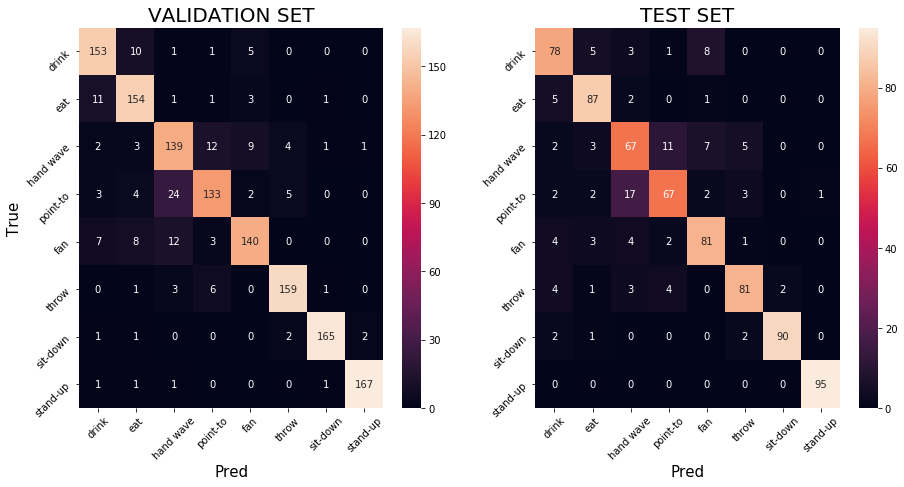

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Val acc: 0.27912087912087913
Test acc: 0.27140974967061926


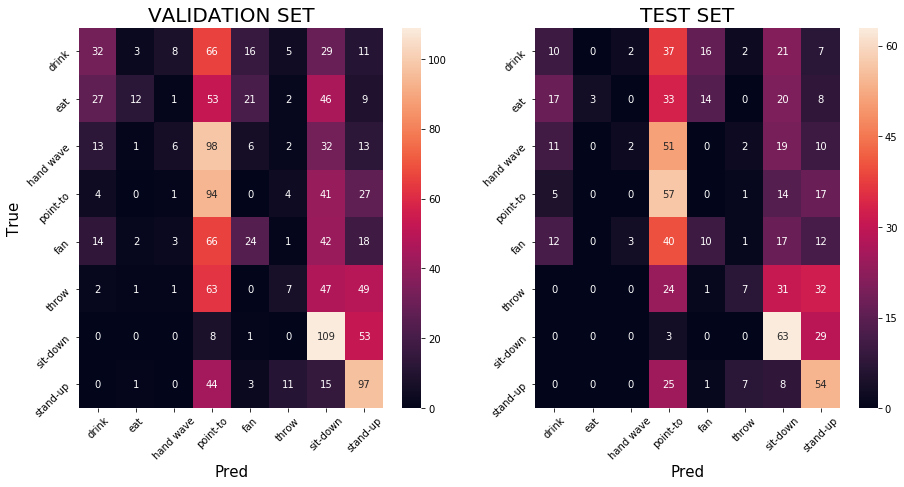

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame


KeyboardInterrupt: 

In [15]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        ## reshaping ###
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
        results.append((val_acc,test_acc,saved_model))

In [14]:
results

[(0.8864468864468864,
  0.8511198945981555,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5'>),
 (0.27912087912087913,
  0.27140974967061926,
  <DirEntry 'PoseNet-101-relativeToVideoCenter.h5'>),
 (0.8827838827838828,
  0.8313570487483531,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame.h5'>),
 (0.2293040293040293,
  0.21080368906455862,
  <DirEntry 'PoseNet-101-relativeToFrameCenter.h5'>),
 (0.1326007326007326,
  0.13175230566534915,
  <DirEntry 'PoseNet-101-relativeToVideoCenter-norm.h5'>),
 (0.18315018315018314,
  0.18972332015810275,
  <DirEntry 'PoseNet-101-relativeToFrameCenter-norm.h5'>),
 (0.8842490842490842,
  0.8642951251646904,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame-norm.h5'>),
 (0.28644688644688643,
  0.29907773386034253,
  <DirEntry 'PoseNet-101-relativeToNextFrame.h5'>),
 (0.21465201465201464, 0.2134387351778656, <DirEntry 'PoseNet-101-norm.h5'>),
 (0.136996336996337,
  0.13175230566534915,
  <DirEntry '

Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


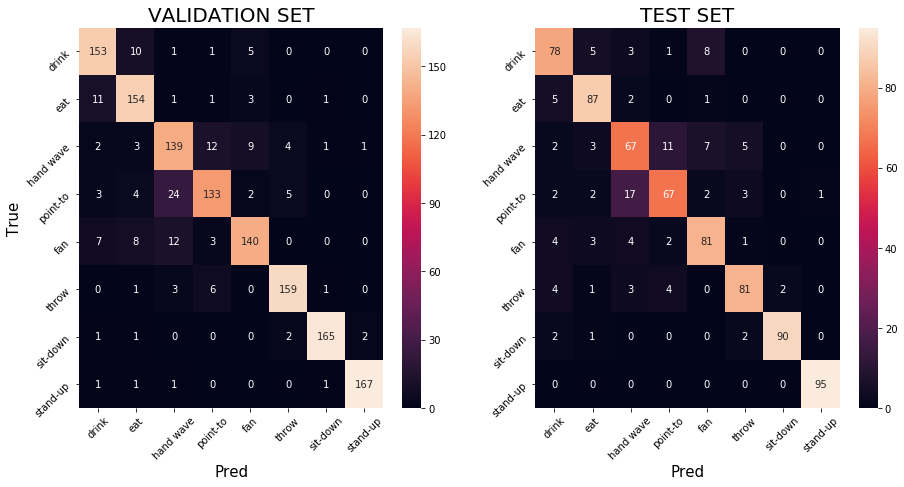

In [34]:
label_order = [1, 2, 31, 38, 49, 7, 8, 9]
model = loadedModel
y_val_pred = [label_order[i] for i in model.predict_classes(X_val)]
y_val_true = [label_order[np.argmax(i)] for i in y_val]
y_test_pred = [label_order[i] for i in model.predict_classes(X_test)]
y_test_true = [label_order[np.argmax(i)] for i in y_test]
val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
print("Val acc:",val_acc)
print("Test acc:",test_acc)
conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
plotConfusionMatrixes(conf_mat_val,conf_mat_test)

In [21]:
y_val_pred

[31,
 2,
 1,
 1,
 2,
 49,
 1,
 7,
 9,
 7,
 1,
 38,
 2,
 8,
 7,
 8,
 1,
 9,
 8,
 2,
 38,
 2,
 38,
 2,
 1,
 1,
 31,
 38,
 31,
 2,
 49,
 31,
 7,
 1,
 31,
 49,
 31,
 31,
 9,
 8,
 49,
 31,
 7,
 2,
 49,
 49,
 38,
 38,
 49,
 9,
 31,
 49,
 2,
 31,
 38,
 7,
 49,
 31,
 1,
 49,
 1,
 38,
 8,
 7,
 31,
 49,
 9,
 9,
 8,
 8,
 7,
 8,
 2,
 7,
 49,
 7,
 2,
 8,
 7,
 7,
 1,
 7,
 31,
 8,
 2,
 7,
 2,
 31,
 31,
 8,
 38,
 9,
 38,
 2,
 9,
 31,
 7,
 8,
 38,
 2,
 31,
 8,
 7,
 49,
 31,
 8,
 49,
 8,
 1,
 38,
 9,
 8,
 2,
 49,
 8,
 38,
 9,
 2,
 49,
 31,
 38,
 38,
 1,
 7,
 31,
 7,
 49,
 49,
 9,
 49,
 8,
 1,
 49,
 9,
 31,
 1,
 1,
 1,
 8,
 7,
 8,
 49,
 9,
 1,
 7,
 8,
 31,
 2,
 38,
 2,
 31,
 8,
 8,
 7,
 2,
 7,
 38,
 49,
 31,
 8,
 49,
 8,
 49,
 49,
 38,
 7,
 9,
 9,
 38,
 7,
 2,
 8,
 2,
 9,
 38,
 8,
 8,
 8,
 7,
 49,
 9,
 8,
 2,
 8,
 31,
 8,
 9,
 38,
 8,
 38,
 31,
 49,
 9,
 8,
 9,
 31,
 49,
 2,
 31,
 1,
 9,
 38,
 8,
 1,
 8,
 8,
 7,
 49,
 1,
 9,
 1,
 38,
 8,
 1,
 8,
 9,
 2,
 49,
 2,
 8,
 1,
 2,
 7,
 1,
 2,
 38,
 49,
 2,
 31,

In [128]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = getValTestAccuracy(loadedModel, X_val, y_val, X_test, y_test)
        print("Validation accuracy:",val_acc,"\nTest accuracy:",test_acc)
        results.append((basename(saved_model),val_acc, test_acc))
#         plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
print("DONE!")

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Validation accuracy: 0.8688644688644689 
Test accuracy: 0.8511198945981555
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each vid

In [114]:
loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)

## continue training

In [13]:
# modelName = 'simple-model.h5'

In [14]:
# from keras.models import load_model
# model = load_model(modelName)

#Continue training
# model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)

# history = model.fit(X_train, y_train,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
# #                     validation_split=0.2
#                     validation_data=(X_val, y_val)
#                    )

Train on 5460 samples, validate on 1365 samples
Epoch 1/10
5460/5460 [==============================] - 35s 6ms/step - loss: 1.2101 - accuracy: 0.4623 - val_loss: 1.2212 - val_accuracy: 0.4718
Epoch 2/10
 368/5460 [=>............................] - ETA: 29s - loss: 1.1121 - accuracy: 0.4810

KeyboardInterrupt: 

# Display classification

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_order = [1, 2, 31, 38, 49, 7, 8, 9]
y_pred = loadedModel.predict_classes(X_val)
# label_order = ["1", "2", "31", "38", "49", "7", "8", "9"]
y_pred_labels = [label_order[i] for i in y_pred]
y_val_labels = [label_order[np.argmax(i)] for i in y_val]

In [45]:
accuracy_score(y_pred=y_pred_labels,y_true=y_val_labels)

0.8827838827838828

In [46]:
yTrue=y_pred_labels
yPred=y_test_labels
conf_mat = confusion_matrix(y_true=yTrue, y_pred=yPred, labels=label_order)
conf_mat

array([[133,  16,   4,   4,   8,   0,   0,   0],
       [ 10, 110,   4,   1,  12,   2,   0,   0],
       [  3,   5, 130,   8,   3,   4,   0,   0],
       [  6,   1,   2, 108,   6,   1,   1,   0],
       [  3,   4,   2,   1, 113,   1,   0,   0],
       [  0,   0,   3,   2,   0, 119,   0,   1],
       [  0,   0,   1,   0,   1,   2, 130,   0],
       [  0,   0,   1,   0,   0,   1,   4, 121]])

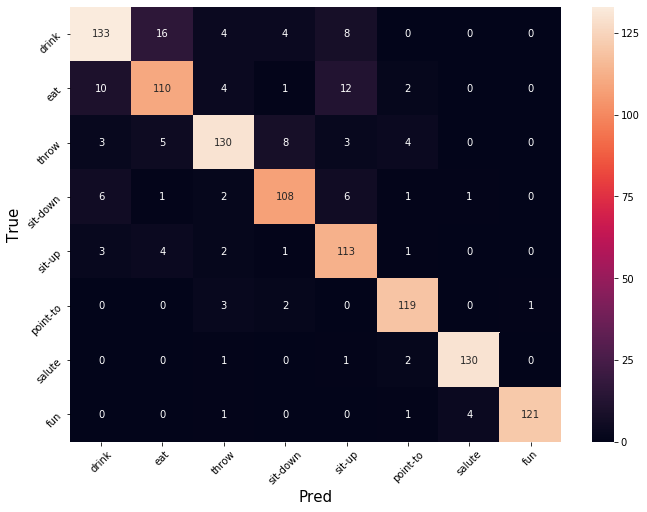

In [41]:
import seaborn as sn
plt.figure(figsize = (11,8))
ax = plt.axes()
labelString = ["drink", "eat", "throw", "sit-down", "sit-up", "point-to", "salute", "fun"]
ax = sn.heatmap(conf_mat, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# plt.title('', fontsize = 20) # title with fontsize 20
plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# ACTION_LABEL_SET = 
# A001  - A002 - A007 - A008     - A009   - A031               - A038   -  A049
# drink - eat - throw - sit down - sit up - point to something - salute - make a fun 


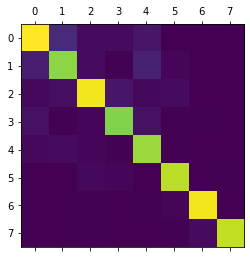

In [42]:
plt.matshow(conf_mat)